In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D, LSTM, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features

from models.models import lstm_model, lstm_model_full

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir ")
options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j1_deltaR,j1_ptrel,j1_phirot,j_z,j_t,j1_pdgid,j_g,j_w,j1_erel,j1_etarot,j_index,j_q
0,0.011056,0.386118,0.000000,0,0,130.0,1,0,0.382772,0.000000,101333,0
1,0.023104,0.107734,0.007236,0,0,211.0,1,0,0.105703,-0.009859,101333,0
2,0.006306,0.094731,-0.002759,0,0,321.0,1,0,0.094339,0.004508,101333,0
3,0.022473,0.042086,-0.014909,0,0,211.0,1,0,0.042913,0.028567,101333,0
4,0.025492,0.039412,-0.003745,0,0,-211.0,1,0,0.038547,-0.018020,101333,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0.380018,0.000350,-0.315306,1,0,111.0,0,0,0.000344,-0.300495,300123134,0
5131609,0.294476,0.000258,-0.349366,1,0,111.0,0,0,0.000256,0.258936,300123134,0
5131610,0.255231,0.000219,-0.270430,1,0,111.0,0,0,0.000215,0.269149,300123134,0
5131611,0.319973,0.000116,-0.341398,1,0,111.0,0,0,0.000115,-0.213081,300123134,0


In [4]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

C:\Users\jjren\LSTM\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

# Self_Build Model

In [16]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = LSTM(16,return_sequences=True,  kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu',kernel_initializer='lecun_uniform',name='lstm_lstm',
         dropout=0.001, recurrent_dropout=0.00001)(Inputs)

x = Flatten()(x)
#x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Load model.py

In [6]:
model = lstm_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 16)                1472      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 85        
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________
None


# Load from json

In [7]:
from keras.models import model_from_json
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Run training

In [17]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(X_train_val, y_train_val, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 28s 15ms/step - loss: 1.1003 - accuracy: 0.6196 - val_loss: 0.9811 - val_accuracy: 0.6751
Epoch 2/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9571 - accuracy: 0.6812 - val_loss: 0.9216 - val_accuracy: 0.6936
Epoch 3/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9195 - accuracy: 0.6895 - val_loss: 0.9187 - val_accuracy: 0.6910
Epoch 4/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9012 - accuracy: 0.6949 - val_loss: 0.8983 - val_accuracy: 0.6975
Epoch 5/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.8900 - accuracy: 0.6984 - val_loss: 0.8752 - val_accuracy: 0.7058
Epoch 6/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.8819 - accuracy: 0.6987 - val_loss: 0.9108 - val_accuracy: 0.6909
Epoch 7/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.8775 - accuracy: 0.7001 - val_loss: 0

1852/1852 [==============================] - 29s 15ms/step - loss: 0.8248 - accuracy: 0.7163 - val_loss: 0.8323 - val_accuracy: 0.7161
Epoch 57/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8243 - accuracy: 0.7170 - val_loss: 0.8381 - val_accuracy: 0.7143
Epoch 58/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8239 - accuracy: 0.7164 - val_loss: 0.8419 - val_accuracy: 0.7101
Epoch 59/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8235 - accuracy: 0.7168 - val_loss: 0.8381 - val_accuracy: 0.7130
Epoch 60/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8237 - accuracy: 0.7162 - val_loss: 0.8760 - val_accuracy: 0.6818
Epoch 61/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8238 - accuracy: 0.7157 - val_loss: 0.8451 - val_accuracy: 0.7079
Epoch 62/100
1852/1852 [==============================] - 29s 16ms/step - loss: 0.8233 - accuracy: 0.7164 - val_loss: 0.8478 

In [19]:
model.save('LSTM')
model.summary()

INFO:tensorflow:Assets written to: LSTM\assets
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Test

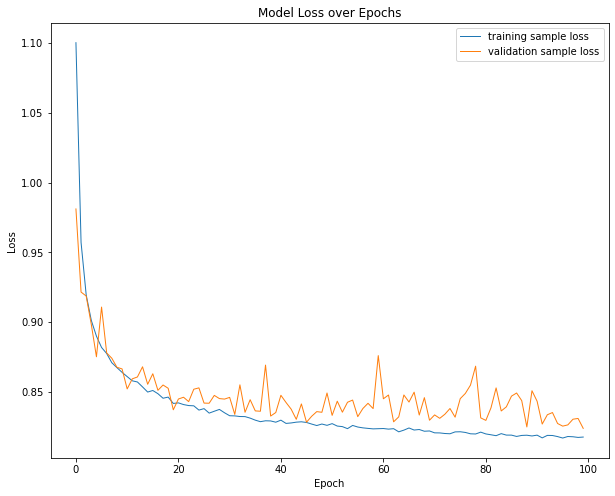

In [20]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

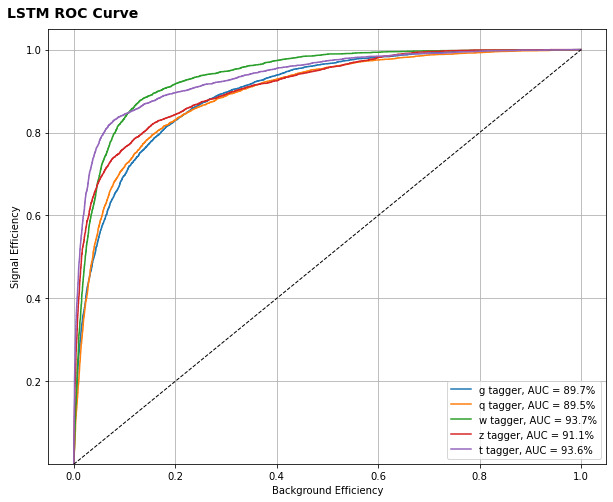

In [21]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')

Text(0.25, 0.9, 'LSTM')

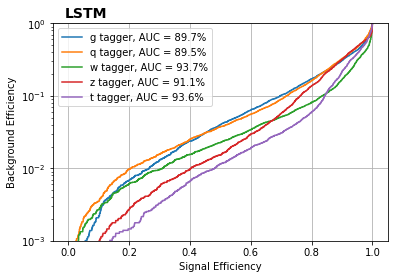

In [22]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)